In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pylab
import networkx as nx
from ipywidgets import interact, IntSlider
import community  
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.palettes import Category20
from bokeh.models import ColorBar, HoverTool

import sys
sys.path.append('../')

from low_rank_rnns.modules import *
from low_rank_rnns import helpers, stats

In [2]:
#https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


In [3]:
#extend/merge peaks

def modify_arr(arr):
    res=arr.copy()
    i=0
    while i<len(arr):
        if arr[i]!=0:
            i2=i
            for j in range(min(7,len(arr)-i)):
                if res[i+j]== -arr[i]:
                    i2-=1
                    break
                else:
                    res[i+j]=arr[i]
                    i2+=1
            i=i2
        i+=1

    return res

In [4]:
df_processed = pd.read_csv('../../dataNotNormalized.csv')
ids = np.unique(df_processed['id'].tolist())



lag=10
threshold= 3
influence=0.5

all_tensors = []

std=5e-2
mean=0
for i in ids:
    
    
    tmp_page = df_processed[df_processed['id'] == i]
    
    r = thresholding_algo(tmp_page['daily_sum'].values, lag=lag, threshold=threshold, influence=influence)
    y = r["signals"]
    y = modify_arr(y)

    #noise = torch.randn_like(torch.from_numpy(y)) * std + mean
    tmp_tensor= torch.tensor(y) #+noise
    all_tensors.append(tmp_tensor.unsqueeze(0))

    
resulted_tensor = torch.cat(all_tensors,0)
resulted_tensor.shape
final_tensor = resulted_tensor.unsqueeze(2)
final_tensor.shape

torch.Size([307, 122, 1])

In [5]:
#not smoothed data

df_processed = pd.read_csv('../../data.csv')
ids = np.unique(df_processed['id'].tolist())




all_tensors = []

for i in ids:   
    tmp_page = df_processed[df_processed['id'] == i]
    
    y = tmp_page['Normalized_daily_sum'].values
    tmp_tensor= torch.tensor(y) 
    all_tensors.append(tmp_tensor.unsqueeze(0))

    
resulted_tensor1 = torch.cat(all_tensors,0)
final_tensor1 = resulted_tensor1.unsqueeze(2)
final_tensor1.shape

torch.Size([307, 122, 1])

In [6]:
#original graph
G = nx.read_gexf("../../newG.gexf")
titles = [n for n in G.nodes()]

In [7]:
#the model is trained and saved, to train again run the cell below

In [8]:
size = 307
#noise_std = 5e-2
#alpha = .2
#n_epochs_fr = 5

#n_epochs = 5

#split_duration = 80
#mask = torch.zeros((307, 122, 1), dtype=torch.float32)
#mask[:,split_duration:,:] = 1
#print(mask.shape)
#u = final_tensor.to(torch.float32)

#x_train = u.clone()
#x_train[:,split_duration:,:] = 0

#_target = u.clone()


#net_fr = FullRankRNN(1, size, 1, noise_std, alpha, rho=1, train_wi=True, train_wo=True)


#_target[:,:split_duration,:] = 0

#train(net_fr, x_train, _target, mask, 4000, lr=1e-4, plot_learning_curve=True, keep_best=True)#1e-5

In [9]:
#torch.save(net_fr.state_dict(), f'mergingPeaks_fr_500epochs,no_random.pt')

In [10]:
#show what the signals look like before and after processing

#after: plot of signals that capture activation/deactivation of pages
#before: plot of normalized signals


slider = IntSlider(value=92, max=size-1, description='Page Index')

def plot_results(_index):
    plt.figure(figsize=(8, 4))
    plt.title(f'page title: {titles[_index]}')
    plt.plot(final_tensor[_index,:], label='used for training')
    plt.legend(loc="lower left")
    plt.ylabel('Visits')
    plt.grid(True)
    plt.show()
    
    
    plt.figure(figsize=(8, 4))
    plt.plot(final_tensor1[_index,:], label='normalized signals')
    plt.xlabel('day')
    plt.ylabel('Visits')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

interact(plot_results, _index=slider)




interactive(children=(IntSlider(value=92, description='Page Index', max=306), Output()), _dom_classes=('widget…

<function __main__.plot_results(_index)>

In [11]:
size = 307
noise_std = 5e-2
alpha = .2
n_epochs_fr = 5

n_epochs = 5

split_duration = 80
mask = torch.zeros((307, 122, 1), dtype=torch.float32)
mask[:,split_duration:,:] = 1
print(mask.shape)
u = final_tensor.to(torch.float32)

x_train = u.clone()
x_train[:,split_duration:,:] = 0

_target = u.clone()
_target[:,:split_duration,:] = 0

net_fr = FullRankRNN(1, size, 1, noise_std, alpha, rho=1, train_wi=True, train_wo=True)

#net = LowRankRNN(1, size, 1, noise_std, alpha, rank=10)


#already trained network, to save time
net_fr.load_state_dict(torch.load(f'mergingPeaks_fr_500epochs,no_random.pt'))



torch.Size([307, 122, 1])


<All keys matched successfully>

In [12]:
out_fr, traj_fr =  net_fr.forward(x_train, return_dynamics=True)
out_fr[:,:split_duration,:] = 0

In [13]:


slider = IntSlider(value=92, max=size-1, description='Page Index')
def plot_results(_index):
    plt.figure(figsize=(8, 4))
    plt.plot(out_fr.detach().numpy()[_index], label='output')
    plt.plot(_target.detach().numpy()[_index], label='target')
    plt.plot(x_train.detach().numpy()[_index], '--', label='input')
    plt.title(f'page title: {titles[_index]}')
    plt.xlabel('day')
    plt.ylabel('Visits')
    plt.legend(loc="lower left")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.show()

interact(plot_results, _index=slider)




interactive(children=(IntSlider(value=92, description='Page Index', max=306), Output()), _dom_classes=('widget…

<function __main__.plot_results(_index)>

In [14]:
#build G_int: graph G with integer labels

node_to_id = {node: i for i, node in enumerate(G.nodes())}

G_int = nx.relabel_nodes(G, node_to_id)

In [15]:
from bokeh.io import output_notebook, show, save
output_notebook()
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

Loading BokehJS ...

In [16]:

partition = community.best_partition(G_int)


plot = figure(tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',title="Graph with Detected Communities")


layout = nx.spring_layout(G_int)
graph_renderer = from_networkx(G_int, layout, scale=1, center=(0, 0))


node_colors = [partition[node] for node in G_int.nodes()]
graph_renderer.node_renderer.data_source.data['community'] = node_colors

node_indices = list(G_int.nodes()) 
graph_renderer.node_renderer.data_source.data['index'] = node_indices


node_titles = titles
graph_renderer.node_renderer.data_source.data['title'] = node_titles

node_degrees = dict(G_int.degree())
max_degree = max(node_degrees.values())
node_sizes = [node_degrees[node] / max_degree * 50 for node in G_int.nodes()]
graph_renderer.node_renderer.data_source.data['size'] = node_sizes
graph_renderer.node_renderer.glyph.size = 'size'


color_mapper = linear_cmap(field_name='community', palette=Category20[20], low=min(node_colors), high=max(node_colors))
graph_renderer.node_renderer.glyph.update(fill_color=color_mapper, fill_alpha=0.8)



color_bar = ColorBar(color_mapper=color_mapper['transform'], width=7, location=(0,0))
plot.add_layout(color_bar, 'right')


edge_renderer = graph_renderer.edge_renderer
edge_renderer.glyph.line_color = 'gray'

plot.renderers.append(graph_renderer)

hover = HoverTool()
hover.tooltips = [("Node", "@index"), ("Community", "@community"), ("Title", "@title")]
plot.add_tools(hover)


show(plot)


In [17]:
#w: connectivity matrix from the fullRankRNN
w = net_fr.wrec
w_max = w.max()
print("max coeff: ", w_max.item())
w_min = w.min()
print("min coeff: ", w_min.item())

max coeff:  0.5556886792182922
min coeff:  -0.5014513731002808


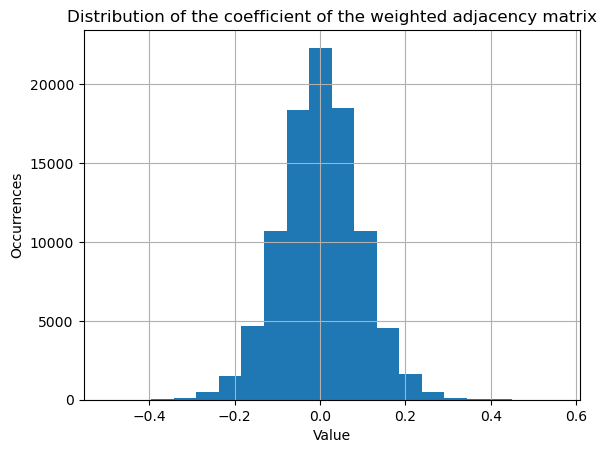

In [18]:
coeff = w.flatten()

plt.hist(coeff.detach().numpy(), bins=20)
plt.xlabel('Value')
plt.ylabel('Occurrences')
plt.title('Distribution of the coefficient of the weighted adjacency matrix')
plt.grid(True)
plt.show()

In [19]:
def threshold_matrix(matrix, threshold):
    unweighted_matrix = np.where(np.absolute(matrix)> threshold, 1, 0)
    return unweighted_matrix

In [20]:
#trying to obtain a 'sparse' matrix
adj_mat = threshold_matrix(w.detach().numpy(), 0.16)

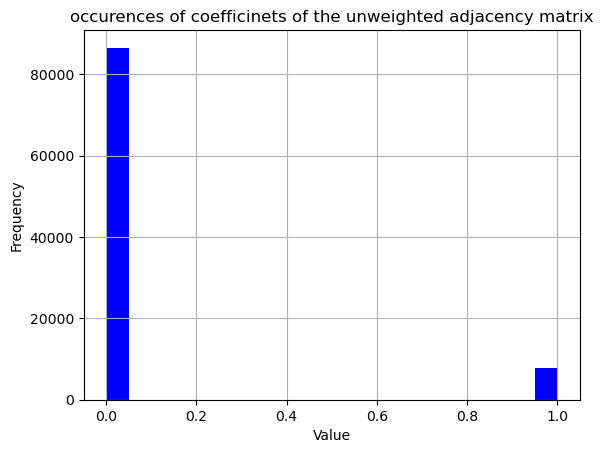

In [21]:
coeff = adj_mat.flatten()

plt.hist(coeff, bins=20, color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('occurences of coefficinets of the unweighted adjacency matrix')
plt.grid(True)
plt.show()

In [22]:
#to reconstruct the graph from its adjacency matrix
G_fr = nx.Graph(adj_mat)

In [23]:
partition = community.best_partition(G_fr)

plot = figure(tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',title="Graph with Detected Communities")


layout = nx.spring_layout(G_fr)    
graph_renderer = from_networkx(G_fr, layout, scale=1, center=(0, 0))


node_colors = [partition[node] for node in G_fr.nodes()]
node_indices = list(G_fr.nodes())  
graph_renderer.node_renderer.data_source.data['index'] = node_indices
graph_renderer.node_renderer.data_source.data['community'] = node_colors
node_titles = titles
graph_renderer.node_renderer.data_source.data['title'] = node_titles



node_degrees = dict(G_fr.degree())
max_degree = max(node_degrees.values())
node_sizes = [node_degrees[node] / max_degree * 40 for node in G_fr.nodes()]
graph_renderer.node_renderer.data_source.data['size'] = node_sizes
graph_renderer.node_renderer.glyph.size = 'size'



color_mapper = linear_cmap(field_name='community', palette=Category20[20], low=min(node_colors), high=max(node_colors))
graph_renderer.node_renderer.glyph.update(fill_color=color_mapper, fill_alpha=0.8)


color_bar = ColorBar(color_mapper=color_mapper['transform'], width=7, location=(0,0))
plot.add_layout(color_bar, 'right')


plot.renderers.append(graph_renderer)

hover = HoverTool()
hover.tooltips = [("Node", "@index"), ("Community", "@community"), ("Title", "@title")]
plot.add_tools(hover)

show(plot)


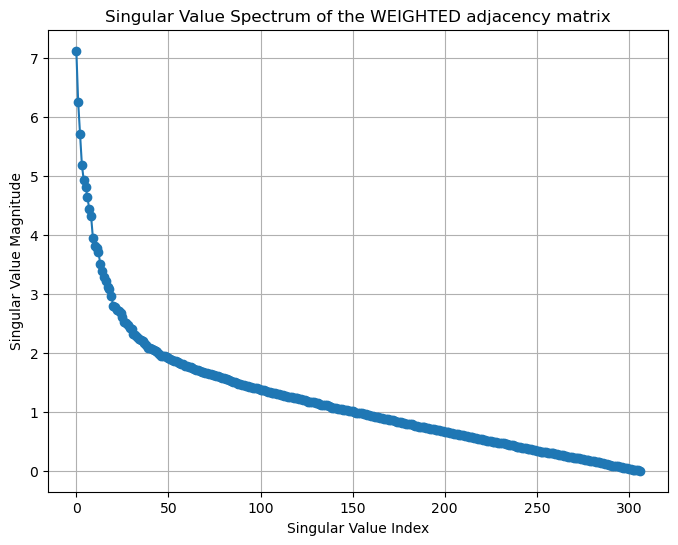

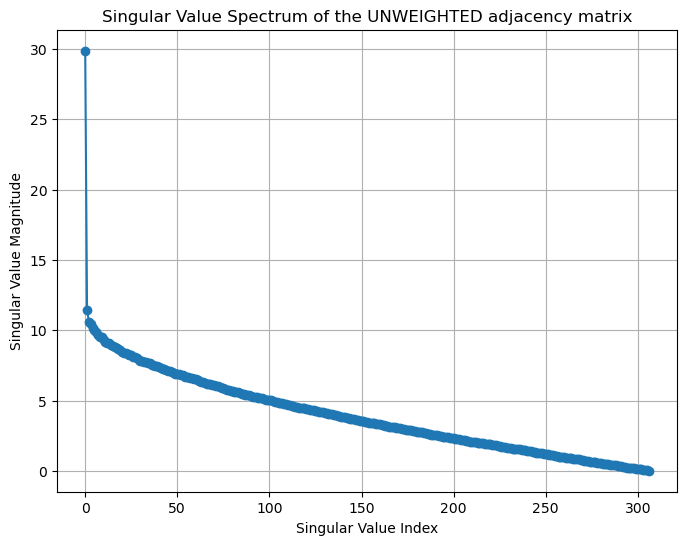

In [24]:
u, s, v = np.linalg.svd(w.detach().numpy())
plt.figure(figsize=(8, 6))
plt.plot(s, marker='o')
plt.title('Singular Value Spectrum of the WEIGHTED adjacency matrix')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.grid(True)
plt.show()


u1, s1, v1 = np.linalg.svd(adj_mat)
plt.figure(figsize=(8, 6))
plt.plot(s1, marker='o')
plt.title('Singular Value Spectrum of the UNWEIGHTED adjacency matrix')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.grid(True)
plt.show()


#w: weight connectivity matrix 
#adj_mat: the unweighted version of w

In [25]:
partition_nodes = {}
for node, part_id in partition.items():
    if part_id not in partition_nodes:
        partition_nodes[part_id] = []
    partition_nodes[part_id].append(node)

# Print nodes in each partition
for part_id, nodes in partition_nodes.items():
    print("Partition", part_id, ":")
    for n in nodes:
        print(titles[n])
    print()

Partition 0 :
Ukraine
Ancient Rome
OECD
Flag carrier
Thomas precession
Introduction to general relativity
Kerr–Newman metric
BBC News
Welsh English
Bohdan Khmelnytsky
Green Ukraine
Leo Esaki
Erwin Schrödinger
Allies of World War II
Berlin
Vera Rubin
Determinism
Scientific law
Scientific theory
Herman Van Rompuy
Mikhail Gorbachev
20th Century Press Archives
Kurgan hypothesis
Wave–particle duality
Chernihiv Governorate
Jews as the chosen people
Periodic table
Ministry of Internal Affairs (Ukraine)
2008 Bucharest summit
List of countries and dependencies by population density
Burghölzli
Ems Ukaz
EuroBasket 2013
Legislature
Kaiser Wilhelm Society
COVID-19 vaccine

Partition 1 :
Kerr metric
Cambridge University Press
King of Ruthenia
Force
NPR
Total war
Twin paradox
Manhattan Project
Andre Geim
Name of Ukraine
Jews
Martinus J. G. Veltman
Arthur B. McDonald
Daniel C. Tsui
Doctoral advisor
Peter Debye
Philosophy of psychology
Philosophy of science
Skeptical Inquirer
Jean-Claude Trichet
Thomas